<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats en mineria de dades · PAC2</p>
<p style="margin: 0; text-align:right;">2019-1 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 2: Mètodes no supervisats


**Important: l'entrega s'ha de fer en format notebook (.ipynb) i en format (.html) on es vegi el codi i els resultats i comentaris de cada exercici. Per a exportar el notebook a html es pot fer des del menú File  →  Download as  →  HTML.**


Al llarg d'aquesta pràctica veurem com aplicar diferents tècniques no supervisades, així com algunes de les seves aplicacions reals:

 1. **Clustering clàssic**: k-means i la regla del colze.
 - **Clustering amb formes i feature engineering**.
 - **Optimització amb reducció de dimensionalitat**: t-SNE.
 - **Aplicació**: agrupació de documents.
   
Per a això necessitarem les següents llibreries:

In [1]:
import random

import numpy as np
import pandas as pd
from sklearn import cluster      # Algoritmes de clustering.
from sklearn import datasets     # Crear datasets.
from sklearn import manifold     # Algoritmes de reducció de dimensionalitat.

# Visualització.
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. Clustering clàssic: k-means i la regla del colze (2 punts)

Partirem d'un conjunt de dades de clients en un negoci *retail* qualsevol (que trobareu en el fitxer *pec2_1.p* amb un *DataFrame* de *pandas* en format *pickle*, o en el *pec2_1.csv* en format *CSV*).

Per cada client es tenen 3 variables:
 - **n_days_per_week**: freqüència d'assistència a la tenda a la setmana
 - **n_month_purchases**: nombre de compres al mes.
 - **avg_month_turnover**: despesa mitjana d'un client al mes.
 
Primer es demana visualitzar les variables per entendre com están distribuïdes i preprocessar-les per aplicar un *k-means*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Visualitzar i preprocessar les variables.  
</div>

Files: 1200
Valors nulls: 0
Valors NaN: 0
                     avg_month_turnover  n_days_per_week  n_month_purchases
Mitja                        215.487550         2.711946           5.120623
Desviació estàndard          180.534793         1.969671           4.362437
Mínim                        -41.444818         0.100000           0.100000
Màxim                        793.734593         7.685392          16.856447
      avg_month_turnover  n_days_per_week  n_month_purchases
905            -2.703113         1.027597           0.267586
958           -41.444818         1.519263           0.261861
1010          -30.163331         0.680807           0.371874
1084          -10.391824         1.273873           0.652735
1161          -11.077900         0.778563           0.447410
                    avg_month_turnover  n_days_per_week  n_month_purchases
avg_month_turnover            1.000000         0.083059           0.298090
n_days_per_week               0.083059         1.000000       

(array([202., 117., 104., 100.,  82., 170., 117.,   8.,   0.,   3.,   6.,
         28.,  33.,  67.,  63.,  61.,  25.,   5.,   7.,   2.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

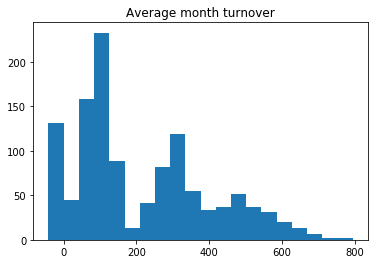

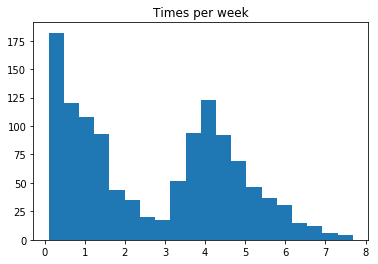

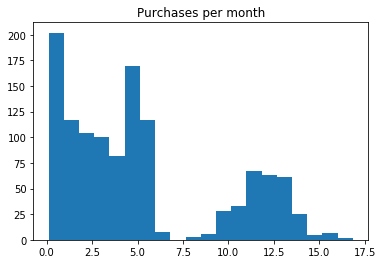

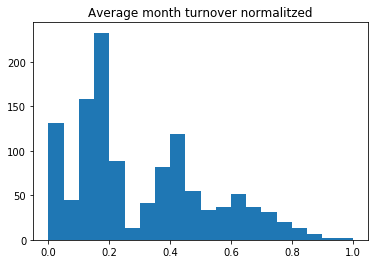

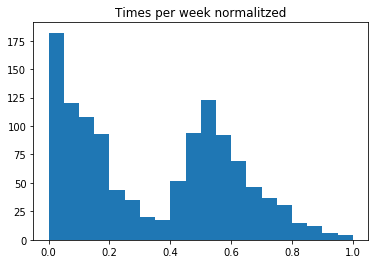

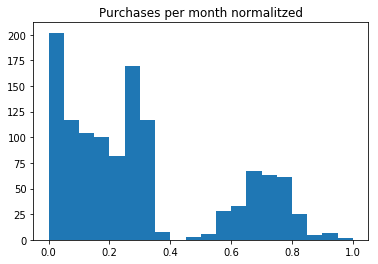

In [2]:
# Carreguem les dades del data set
retailDataSet = pd.read_csv("pec2_1.csv")

# Obtenim i mostrem el nombre de files del dataset
nombre_files = np.size(retailDataSet,0)
print("Files: " + str(nombre_files))
print("Valors nulls: "+str(np.count_nonzero(pd.isnull(retailDataSet))))
print("Valors NaN: "+str(np.count_nonzero(np.isnan(retailDataSet)))) 

# Mitja i desviació típica dels atributs
retailDataSetResumen = pd.DataFrame([retailDataSet.mean(), retailDataSet.std(), retailDataSet.min(), retailDataSet.max()], 
                                    index=['Mitja', 'Desviació estàndard', 'Mínim', 'Màxim'])
print(retailDataSetResumen)
# Podem veure com les variables no estan a la mateixa escala. Si no volem que un atribut tingui més pes que un altre,
# s'hauran de normalitzar
# Crida l'atenció que hi hagi valors negatius per avg_month_turnover. Són:
print(retailDataSet[retailDataSet.avg_month_turnover < 0])
# Com l'objectiu és entendre les despeses per client, aquestes dades sembla que no són representatives
# Però jo crec que sí que les hem d'incorporar, ja que és possible que als altres valors d'avg tambè estiguin 
# incorporades les devolucions (per exemple: 0 pot ser qualcú que ha comprat un producte i l'ha tornat el mateix dia)
# Crec que es podrien excloure si tinguèssim tots els registres de compres i no la informació agrupada

# Pintem els atributs
# Average month turnover 
figamt, axsamt = plt.subplots(1, 1, tight_layout=False)
axsamt.set_title("Average month turnover")
axsamt.hist(retailDataSet.avg_month_turnover, bins=20)  

# Times per week 
figtpw, axstpw = plt.subplots(1, 1, tight_layout=False)
axstpw.set_title("Times per week")
axstpw.hist(retailDataSet.n_days_per_week, bins=20) 

# Purchases per month
figppm, axsppm = plt.subplots(1, 1, tight_layout=False)
axsppm.set_title("Purchases per month")
axsppm.hist(retailDataSet.n_month_purchases, bins=20)  

# A primera vista, sembla que hi ha una correlació important entre variables
# Mostrem les correlacions entre variables
retailDataSetCorr = retailDataSet.corr()
print(retailDataSetCorr)
# Podem veure que hi ha una correlació molt forta entre n_days_per_week i n_month_purchases

# Normalitzem les dades
retailDataSetNorm = pd.DataFrame()
avg_month_turnover_norm = []
n_days_per_week_norm = []
n_month_purchases_norm = []
avg_month_turnover_dif = retailDataSet.avg_month_turnover.max() - retailDataSet.avg_month_turnover.min()
n_days_per_week_norm_dif = retailDataSet.n_days_per_week.max() - retailDataSet.n_days_per_week.min()
n_month_purchases_norm_dif = retailDataSet.n_month_purchases.max() - retailDataSet.n_month_purchases.min()
for index, row in retailDataSet.iterrows():    
    avg_month_turnover_norm.append((row['avg_month_turnover'] - 
                                    retailDataSet.avg_month_turnover.min())/avg_month_turnover_dif)
    n_days_per_week_norm.append((row['n_days_per_week'] - 
                                    retailDataSet.n_days_per_week.min())/n_days_per_week_norm_dif)
    n_month_purchases_norm.append((row['n_month_purchases'] - 
                                    retailDataSet.n_month_purchases.min())/n_month_purchases_norm_dif)    
# Creem l'estructura normalitzada retailDataSetNorm, que utilitzarem per a fer l'anàlisi
retailDataSetNorm['avg_month_turnover_norm'] = avg_month_turnover_norm 
retailDataSetNorm['n_days_per_week_norm'] = n_days_per_week_norm
retailDataSetNorm['n_month_purchases_norm'] = n_month_purchases_norm
# Guardem la informació a la pròpia estructura
retailDataSet['avg_month_turnover_norm'] = avg_month_turnover_norm 
retailDataSet['n_days_per_week_norm'] = n_days_per_week_norm
retailDataSet['n_month_purchases_norm'] = n_month_purchases_norm

# Pintem les dades normalitzades

# Average month turnover
figamtnorm, axsamtnorm = plt.subplots(1, 1, tight_layout=False)
axsamtnorm.set_title("Average month turnover normalitzed")
axsamtnorm.hist(retailDataSetNorm.avg_month_turnover_norm, bins=20)  

# Times per week 
figtpwnorm, axstpwnorm = plt.subplots(1, 1, tight_layout=False)
axstpwnorm.set_title("Times per week normalitzed")
axstpwnorm.hist(retailDataSetNorm.n_days_per_week_norm, bins=20) 

# Purchases per month
figppmnorm, axsppmnorm = plt.subplots(1, 1, tight_layout=False)
axsppmnorm.set_title("Purchases per month normalitzed")
axsppmnorm.hist(retailDataSetNorm.n_month_purchases_norm, bins=20)

Es demana estimar el nombre de clústers a detectar per *k-means*. Una tècnica per estimar $k$ és, com s'explica a la teoria:
> Els criteris anteriors (minimització de distàncies intra grup o maximització de distàncies inter grup) poden usar-se per establir un valor adequat per al paràmetre k. Valors k per als quals ja no s'aconsegueixen millores significatives en l'homogeneïtat interna dels segments o l'heterogeneïtat entre segments diferents, haurien de descartar-se.

El que popularment es coneix com *regla del colze*.

Primer cal calcular la suma dels errors quadràtics ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consisteix en la suma de tots els errors (distància de cada punt al seu centroide assignat) al quadrat.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

On $K$ és el nombre de clústers a buscar per *k-means*, $x \in C_i$ són els punts que pertanyen a l'i-èsim clúster, $c_i $ és el centroide del clúster $C_i$ (al que pertany el punt $x$), i $euclidean$ és la [distància euclidiana](https://en.wikipedia.org/wiki/Euclidean_distance).

Aquest procediment realitzat per a cada possible valor $k$, resulta en una funció monòtona decreixent on l'eix $x$ representa els diferents valors de $k$, i l'eix $i$ el $SSE$. Intuïtivament es podrà observar un significatiu descens de l'error, que indicarà el valor idoni de $ k $.

**Es demana realitzar la representació gràfica de la regla del colze amb la seva interpretació, utilitzant la llibreria `` `matplotlib``` i la implementació en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> càlcul i visualització de la regla del colze.  
</div>

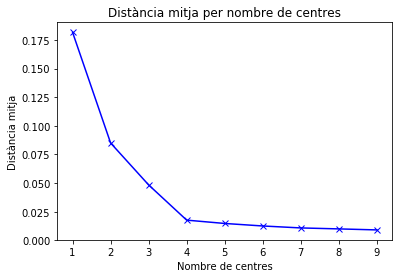

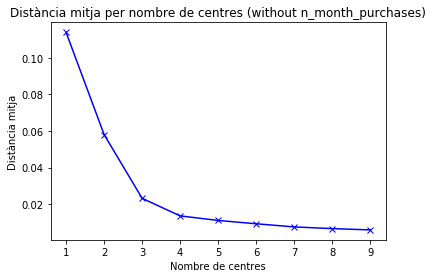

In [3]:
from scipy.spatial.distance import cdist
# Mostrem com es comporta per fins a 10 centres
K = range(1, 10)
meandistortions = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(retailDataSetNorm)
    meandistortions.append(sum(np.min(cdist(retailDataSetNorm, kmeans.cluster_centers_, 'euclidean') ** 2, axis=1)) 
                           / retailDataSetNorm.shape[0])
    
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('Nombre de centres')
plt.ylabel('Distància mitja')
plt.title('Distància mitja per nombre de centres')
plt.show()   

# Com es pot veure, la pendent es comença a suavitzar a partir dels 4 nuclis

# Si eliminem la columna n_month_purchases (està fortament correlacionada amb n_days_per_week) podem veure 
#  que el resultat és molt similar
retailDataSetNormV2 = pd.DataFrame()
retailDataSetNormV2['avg_month_turnover_norm'] = avg_month_turnover_norm 
retailDataSetNormV2['n_days_per_week_norm'] = n_days_per_week_norm
meandistortionsV2 = []
for k in K:
    kmeansV2 = cluster.KMeans(n_clusters=k)
    kmeansV2.fit(retailDataSetNormV2)
    meandistortionsV2.append(sum(np.min(cdist(retailDataSetNormV2, kmeansV2.cluster_centers_, 'euclidean') ** 2, axis=1)) 
                           / retailDataSetNormV2.shape[0])
    
plt.plot(K, meandistortionsV2, 'bx-')
plt.xlabel('Nombre de centres')
plt.ylabel('Distància mitja')
plt.title('Distància mitja per nombre de centres (without n_month_purchases)')
plt.show()  

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> ¿Què s'interpreta a la gráfica? ¿Com podria millorar-se l'elecció de $k$?.  
</div>

In [4]:
# La qualitat dels nuclis està relacionada amb l'error mitjà (distáncia entre el valor observat i el nucli)
# Com menor sigui l'error (distància mitja a la gràfica), mijor és el model
# Evidentment, s'ha de trobar el compromís entre l'error mitjà i el nombre de nuclis (si el nombre de nuclis és igual al 
# nombre d'observacions, l'error és 0)
# Mirant la gràfica, sembla que la pendent es comença a suavitzar a partir de 4

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Observant els centroides de cada clúster, quins tipus d'usuaris descriuen cada clúster?
</div>

In [5]:
import math  

# Amb tres variables, podem veure els centres (k = 4)
clusters = cluster.KMeans(n_clusters=4, max_iter=1000)
kmeansint = clusters.fit(retailDataSetNorm)    
centroids = kmeansint.cluster_centers_
print(centroids)

# Amb dues variables (llevant la columna fortament correlacionada), podem veure els centres (k = 4)
clusters = cluster.KMeans(n_clusters=4, max_iter=1000)
kmeansint = clusters.fit(retailDataSetNormV2)    
centroids = kmeansint.cluster_centers_
print(centroids)
  
def distance(ds, center):
    turnover = ds[["avg_month_turnover_norm"][0]] - center[0]
    turnover = turnover ** 2
    n_days = ds[["n_days_per_week_norm"][0]] - center[1]
    n_days = n_days ** 2
    n_month = ds[["n_month_purchases_norm"][0]] - center[2]
    n_month = n_month ** 2
    total = turnover + n_days + n_month
    return total    


kmeansint = clusters.fit(retailDataSetNorm)    

for center in kmeansint.cluster_centers_:
    distMin = 1;
    for index, row in retailDataSet.iterrows():
        distMinAux = distance(row, center)
        if distMinAux < distMin:
            distMin = distMinAux
            retailDataSetAux = row
    print("")                        
    print("centre:")
    print(str(center))
    print("distància mínima centre:" + str(distMin))
    print("usuari característic:")
    print(str(retailDataSetAux))    



[[0.64888252 0.15175766 0.16899211]
 [0.17023367 0.51330559 0.29418709]
 [0.40703499 0.6464966  0.70940991]
 [0.11329995 0.08032122 0.05008262]]
[[0.41408749 0.67050625]
 [0.11269116 0.0806466 ]
 [0.64556207 0.154241  ]
 [0.18556337 0.50938463]]

centre:
[0.17023367 0.51330559 0.29418709]
distància mínima centre:0.00010894608758959978
usuari característic:
avg_month_turnover         99.032442
n_days_per_week             4.017807
n_month_purchases           4.866513
avg_month_turnover_norm     0.168200
n_days_per_week_norm        0.516494
n_month_purchases_norm      0.284458
Name: 278, dtype: float64

centre:
[0.64888252 0.15175766 0.16899211]
distància mínima centre:0.0006145332174495733
usuari característic:
avg_month_turnover         497.721691
n_days_per_week              1.141543
n_month_purchases            2.598765
avg_month_turnover_norm      0.645570
n_days_per_week_norm         0.137309
n_month_purchases_norm       0.149123
Name: 877, dtype: float64

centre:
[0.11329995 0.0803

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>[OPCIONAL] Implementació:</strong> visualitza el conjunt de dades en 3 dimensions, on els punts del mateix color pertanyen al mateix clúster. 
</div>

(0, avg_month_turnover_norm    0.179334
n_days_per_week_norm       0.417010
n_month_purchases_norm     0.323642
Name: 0, dtype: float64)
(1, avg_month_turnover_norm    0.170859
n_days_per_week_norm       0.671993
n_month_purchases_norm     0.310513
Name: 1, dtype: float64)
(2, avg_month_turnover_norm    0.122542
n_days_per_week_norm       0.405631
n_month_purchases_norm     0.297345
Name: 2, dtype: float64)
(3, avg_month_turnover_norm    0.158495
n_days_per_week_norm       0.538502
n_month_purchases_norm     0.308693
Name: 3, dtype: float64)
(4, avg_month_turnover_norm    0.187243
n_days_per_week_norm       0.426529
n_month_purchases_norm     0.277803
Name: 4, dtype: float64)
(5, avg_month_turnover_norm    0.140797
n_days_per_week_norm       0.503142
n_month_purchases_norm     0.263264
Name: 5, dtype: float64)
(6, avg_month_turnover_norm    0.133802
n_days_per_week_norm       0.557922
n_month_purchases_norm     0.283398
Name: 6, dtype: float64)
(7, avg_month_turnover_norm    0.176360
n

Name: 396, dtype: float64)
(397, avg_month_turnover_norm    0.430701
n_days_per_week_norm       1.000000
n_month_purchases_norm     0.753054
Name: 397, dtype: float64)
(398, avg_month_turnover_norm    0.338626
n_days_per_week_norm       0.756488
n_month_purchases_norm     0.615111
Name: 398, dtype: float64)
(399, avg_month_turnover_norm    0.400104
n_days_per_week_norm       0.560522
n_month_purchases_norm     0.569402
Name: 399, dtype: float64)
(400, avg_month_turnover_norm    0.433398
n_days_per_week_norm       0.624321
n_month_purchases_norm     0.698158
Name: 400, dtype: float64)
(401, avg_month_turnover_norm    0.373723
n_days_per_week_norm       0.743588
n_month_purchases_norm     0.736377
Name: 401, dtype: float64)
(402, avg_month_turnover_norm    0.412587
n_days_per_week_norm       0.668192
n_month_purchases_norm     0.785341
Name: 402, dtype: float64)
(403, avg_month_turnover_norm    0.442705
n_days_per_week_norm       0.535661
n_month_purchases_norm     0.617996
Name: 403, dt

Name: 816, dtype: float64)
(817, avg_month_turnover_norm    0.741235
n_days_per_week_norm       0.241487
n_month_purchases_norm     0.262038
Name: 817, dtype: float64)
(818, avg_month_turnover_norm    0.623993
n_days_per_week_norm       0.203054
n_month_purchases_norm     0.172274
Name: 818, dtype: float64)
(819, avg_month_turnover_norm    0.602195
n_days_per_week_norm       0.012155
n_month_purchases_norm     0.196805
Name: 819, dtype: float64)
(820, avg_month_turnover_norm    0.808155
n_days_per_week_norm       0.105062
n_month_purchases_norm     0.138825
Name: 820, dtype: float64)
(821, avg_month_turnover_norm    0.795453
n_days_per_week_norm       0.100591
n_month_purchases_norm     0.182492
Name: 821, dtype: float64)
(822, avg_month_turnover_norm    0.559987
n_days_per_week_norm       0.309974
n_month_purchases_norm     0.094468
Name: 822, dtype: float64)
(823, avg_month_turnover_norm    0.657189
n_days_per_week_norm       0.055216
n_month_purchases_norm     0.162171
Name: 823, dt

Name: 1157, dtype: float64)
(1158, avg_month_turnover_norm    0.126525
n_days_per_week_norm       0.055115
n_month_purchases_norm     0.022413
Name: 1158, dtype: float64)
(1159, avg_month_turnover_norm    0.205063
n_days_per_week_norm       0.154991
n_month_purchases_norm     0.061437
Name: 1159, dtype: float64)
(1160, avg_month_turnover_norm    0.107399
n_days_per_week_norm       0.160930
n_month_purchases_norm     0.159039
Name: 1160, dtype: float64)
(1161, avg_month_turnover_norm    0.036360
n_days_per_week_norm       0.089457
n_month_purchases_norm     0.020733
Name: 1161, dtype: float64)
(1162, avg_month_turnover_norm    0.049744
n_days_per_week_norm       0.000000
n_month_purchases_norm     0.000000
Name: 1162, dtype: float64)
(1163, avg_month_turnover_norm    0.317258
n_days_per_week_norm       0.082380
n_month_purchases_norm     0.055256
Name: 1163, dtype: float64)
(1164, avg_month_turnover_norm    0.162970
n_days_per_week_norm       0.133084
n_month_purchases_norm     0.149214

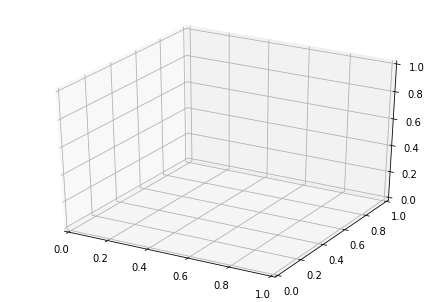

De forma **optativa** es planteja **realitzar l'apartat anterior amb una implementació pròpia de l'algorisme * k-means***.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>[OPCIONAL] Implementació:</strong> algorisme <i>k-means</i> de zero.  
</div>

En aquest cas, amb 2 dimensions, és molt senzill inferir el nombre de clústers visualitzant les dades. Però aquest mètode és de gran utilitat quan es compta amb dades d'alta dimensionalitat.

## 2. Clustering amb formes i feature engineering (4 punts)

Però no tots els conjunts de dades són com els de l'exercici anterior. Per a aquesta segona part emprarem el següent conjunt de dades:

In [6]:
data_circles = ('circles', *datasets.make_circles(n_samples=1000, factor=.5, noise=.05))

On *data_circles* és una tupla amb tres posicions: el nom del conjunt de dades i els dos valors retornats per la funció que genera el conjunt de dades:

In [7]:
datasets.make_circles?

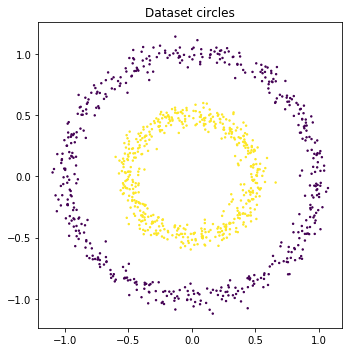

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(data_circles[1][:,0], data_circles[1][:,1], c=data_circles[2], s=2)
ax.set_title('Dataset {}'.format(data_circles[0]))
plt.tight_layout()

### 2 a. Trobant els clústers amb *k-means*

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica la regla del colze per decidir el valor de $k$.
</div>

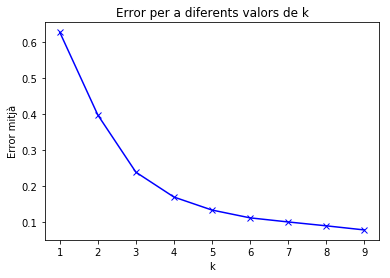

In [9]:
K = range(1, 10)
meandistortions = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(data_circles[1])
    meandistortions.append(sum(np.min(cdist(data_circles[1], kmeans.cluster_centers_, 'euclidean') ** 2, axis=1)) 
                           / data_circles[1].shape[0])    
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Error mitjà')
plt.title('Error per a diferents valors de k')
plt.show()   

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica <i>k-means</i> amb el valor de $k$ escollit.
<br>
Visualitza el resultat en un <i>scatter plot</i> representant cada clúster amb un color distintiu.
</div>

[[ 0.44565438  0.53692202]
 [-0.04284897 -0.69143244]
 [-0.69072435 -0.12946667]
 [ 0.66047258 -0.2488016 ]
 [-0.33941514  0.62650961]]


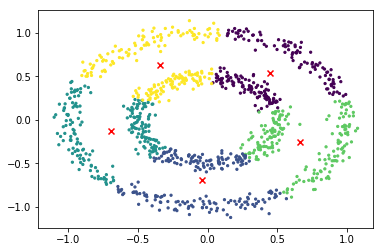

In [413]:
# Agafam el valor de 5; sembla que no hi ha millora significativa
clusters = cluster.KMeans(n_clusters=5, max_iter=1000)
kmeansint = clusters.fit(data_circles[1])    
centroids = kmeansint.cluster_centers_
print(centroids)

y_kmeans = kmeansint.predict(data_circles[1])
plt.scatter(data_circles[1][:, 0], data_circles[1][:, 1], c=y_kmeans, s=5, cmap='viridis')
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi: </strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.
</div>

In [11]:
# Intuitivament, sembla clar que hi ha dos grups: el cercle interior i l'exterior.
# Les variables de les que disposem no inclouen la distància al centre; només tenim la posició absoluta (x i y)
# Està clar que l'algorisme ha agrupat per aquesta posició. Els centroids dels grups (pintats amb una creu vermella) 
#  minimitzen la distància dels punts. 
#Això fa que es produeixi aquest resultat.

### 2 b. Més enllà de K-Means: algorismes basats en densitat

En aquest apartat es demana aplicar clustering per densitat com [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) al conjunt de dades anterior per a poder trobar els dos clústers inicials.

<br>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong> Implementació: </strong> prova la implementació de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html"> DBSCAN en scikit-learn</a> jugant amb els paràmetres <i> eps </i> i <i> min_samples </i> per trobar les 2 estructures subjacents (i <i> outliers</i>).
</div>

Number of clusters: 2
Estimated number of noise points: 0


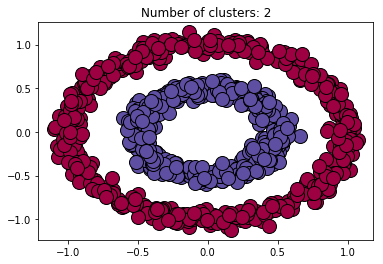

In [13]:
from sklearn import metrics
# Compute DBSCAN
db = cluster.DBSCAN(eps=0.2, min_samples=5).fit(data_circles[1])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = 2
n_noise_ = list(labels).count(-1)

print('Number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data_circles[1][class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data_circles[1][class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Number of clusters: %d' % n_clusters_)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong> Anàlisi: </strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.
</div>

In [14]:
# Com es pot veure, amb eps=0.2 i min_samples=5, totes les dades queden perfectament classificades. 
# L'algoritme agrupa els punts que estiguin entre sí a una distància màxima d'eps. Si eps és molt alt 
#  (per exemple, 1) l'algorisme ho agrupa tot en un únic cluster. Si és massa petit, queden valors sense agruprar. 
# L'algorisme agrupa un mínim de min_samples valors. Si no arriba, els hi considera renou. Si el valor és molt alt, 
#  molt de valors queden sense classificar. Si és massa baix, pot agrupar renou com si fossin dades rellevants.

### 2 c. Més enllà de K-Means: algorismes jeràrquics

En aquest apartat es demana visualitzar mitjançant un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcció progressiva dels grups mitjançant un algorisme jeràrquic aglomeratiu (estratègia *bottom-up*). Amb això es pretén trobar un mètode gràfic per entendre el comportament de l'algorisme i trobar els dos clústers.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html"> clustering jeràrquic de SciPy </a> provant diferents <a href = "https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i> linkage </i> </a> permetent identificar els clústers subjacents (mostrant el seu resultat) i la seva dendrograma.
</div>

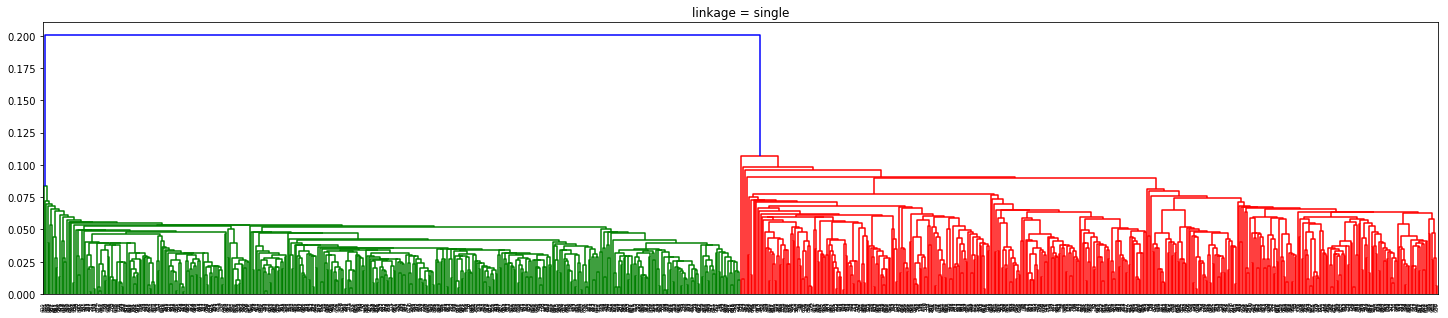

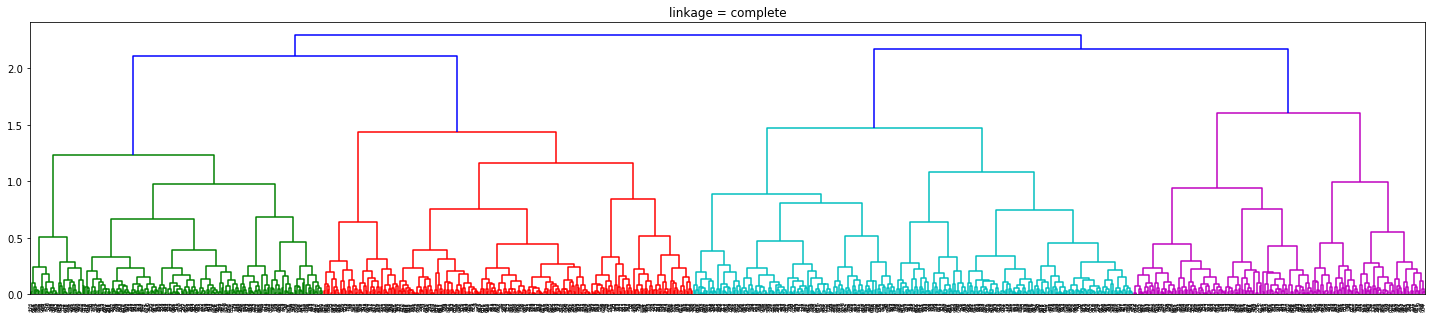

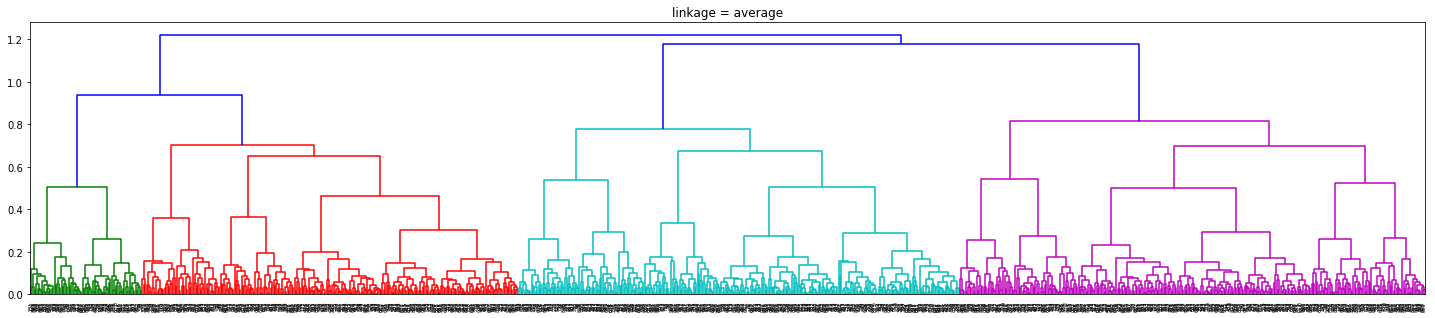

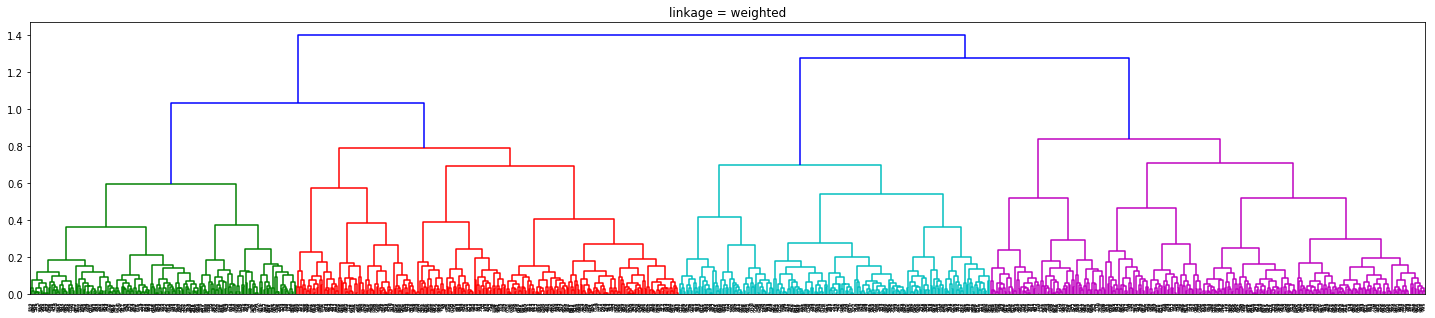

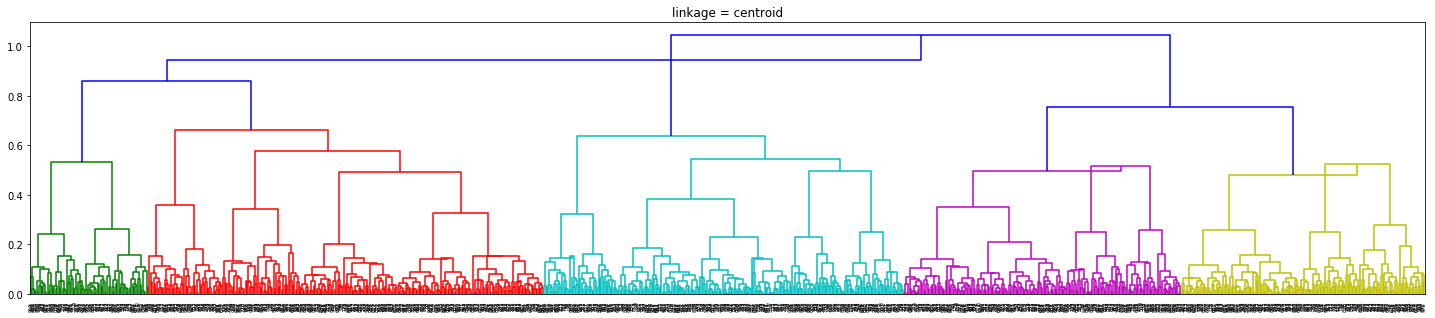

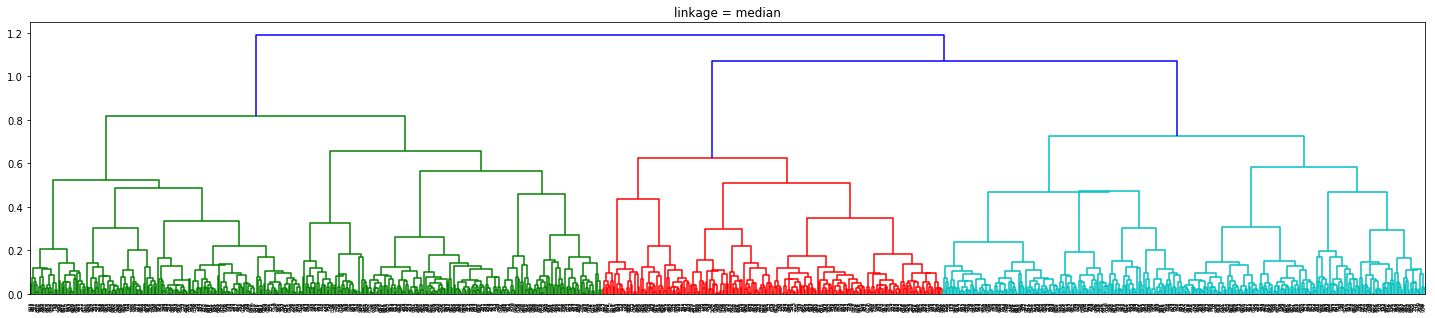

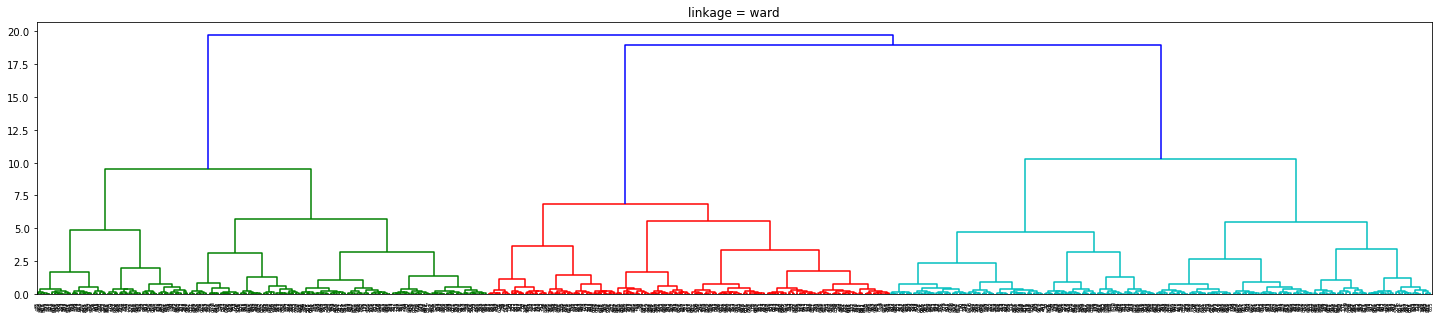

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage

def dendrograma(method):
    Z = linkage(data_circles[1], method)
    fig = plt.figure(figsize=(25, 5))
    dn = dendrogram(Z)
    plt.title("linkage = " + method)
    plt.show()

dendrograma('single')    
dendrograma('complete')
dendrograma('average')
dendrograma('weighted')
dendrograma('centroid')
dendrograma('median')
dendrograma('ward')


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi: </strong> Interpreta el dendrograma i comenta quin criteri d'enllaç s'ha comportat millor. Per què?
</div>

In [16]:
# Els dendrogrames classifiquen els punts segons diferents estratègies. Cada color indica un grup. Com sabem que cerquem
#  dos grups, el criteri que millor s'ha comportat és el simple (2 grups) seguit del ward (3 grups). 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi: </strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.
</div>

In [17]:
# Al començament del procés, cada element és un cluster. L'algorisme va agrupant clusters; agafa 2 segons un criteri i crea
#  un de nou, eliminant els dos clusters inicials. El procés acaba quan només queda un cluster.
# En aquest cas el mètode simple funciona molt bé perque agrupa clusters prenent com a criteri la distància mínima 
#  entre ells . Com ja hem vist abans, la característica principal dels grups de data_circles es que els elements estan 
#  molt aprop els uns dels altres (malgran no s'agrupen entorn a un nucli).

### 2 d. *Feature engineering* i agrupament

Alguns dels algorismes anteriors es basen en unes suposicions que no complien al conjunt de dades. Moltes vegades enlloc d'optar per algorismes més complexes o que requereixen més còmput, es poden transformar les dades per poder aplicar amb èxit tècniques més senzilles. Això és un clar exemple de *feature engineering*.

<br>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> transforma els punts anteriors del conjunt de dades a un nou espai de 2 dimensions:
<ul>
<li> Ràdio, o distància al punt (0,0)
<li> Angle, pel que fa al vector (1,0)
</ul>
Perquè totes les dimensions tinguin el mateix pes, <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html"> normalitzarem entre 0 i 1 d'acord al seu màxim i mínim </a>.
<br>
Visualitzar els punts del "nou" conjunt de dades.
</div>

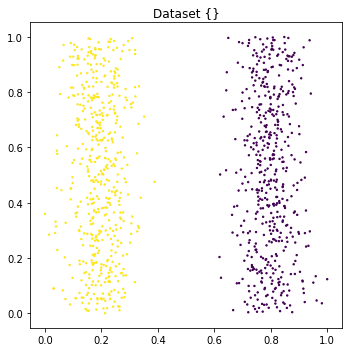

In [18]:
# Mètode que calcula la distància al centre
def distancia(x, y):
    val = math.sqrt(x**2 + y**2)
    return val

# Mètode que calcula l'angle respecte a l'eix (1,0)
def theta(x, y):
    val = math.atan(y/x)
    return val

# Mètode per a normalitzar un vector
def normalize(vector):
    vectorNorm = []
    minVector = min(vector)
    maxVector = max(vector)
    difVector = maxVector - minVector
    i = 0
    for row in vector:
        vectorNorm.append((vector[i] - minVector)/difVector)
        i = i + 1  
    return vectorNorm                

# Calculem els vectors de distàncies i angles
distancies = []
thetas = []
for dc in data_circles[1]:
    distancies.append(distancia(dc[0], dc[1]))
    thetas.append(theta(dc[0], dc[1]))    
    
# Normalitzem els vectors    
distancies = normalize(distancies)
thetas = normalize(thetas)

# Creem el data frame amb els dos vectors
data_circles_norm = pd.DataFrame()
data_circles_norm['distance'] = distancies 
data_circles_norm['angle'] = thetas
data_circles_norm['res'] = data_circles[2]

# Pintem les dades
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(data_circles_norm['distance'], data_circles_norm['angle'], c=data_circles_norm['res'], s=2)
ax.set_title('Dataset {}')
plt.tight_layout()
    

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi: </strong> Què creus que succeirà en aplicar els anteriors algorismes en aquest "nou" conjunt de dades?
</div>

In [19]:
# Crec que funcionaràn molt millor. Es pot veure clarament la diferència entre grups.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica cada un dels algorismes d'agrupament anteriors que no hagin pogut localitzar adequadament els dos clústers originals per intentar trobar-los en aquest "nou" espai. Ajusta els paràmetres necessaris per facilitar la seva detecció.
<br><br>
Per a cada algorisme, visualitza els clústers trobats en 2 imatges:
<ul>
<li> En el "nou" espai (ràdio i angle).
<li> A l'espai original (posició x i y), però NO amb les etiquetes (pertinença al clúster) obtingudes en aplicar els algorismes sobre el conjunt de dades original, sinó amb les etiquetes obtingudes al realitzar el clustering en el "nou" espai. A veure si així s'aconsegueixen solucionar els problemes inicials.
</ul>
</div>

[[0.79703236 0.50347327]
 [0.19273047 0.50079697]]


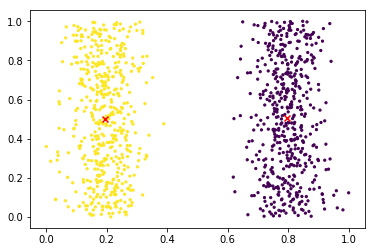

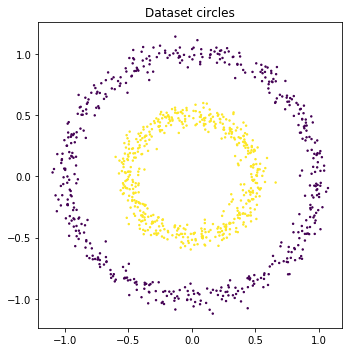

In [414]:
# Comprovem que el clustering de dades (k=2) funciona bé amb el nou model de dades
# Agafam 2 clusters
clusters = cluster.KMeans(n_clusters=2, max_iter=1000)
kmeansint = clusters.fit(data_circles_norm[['distance', 'angle']])    
centroids = kmeansint.cluster_centers_
# Pintem els valors dels centroids
print(centroids)

# Pintem les dades depenguent de k
kmeans_norm = kmeansint.predict(data_circles_norm[['distance', 'angle']])
plt.scatter(data_circles_norm['distance'], data_circles_norm['angle'], c=kmeans_norm, s=5, cmap='viridis')
plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')

# Pintem les dades originals amb l'etiqueta calculada segons el nou mètode
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(data_circles[1][:,0], data_circles[1][:,1], c=kmeans_norm, s=2)
ax.set_title('Dataset {}'.format(data_circles[0]))
plt.tight_layout()


## 3. Optimizació amb reducció de dimensionalitat: t-SNE (1 punt)

Com ja s'ha vist, l'algorisme [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ideat per [van der Maaten i Hinton](https://lvdmaaten.github.io/tsne/) difereix de PCA en què no tracta de maximitzar la variància explicada. Intuïtivament, t-SNE tracta de que el veïnatge d'un punt en baixa dimensionalitat sigui el mateix que l'original (mantingui les distàncies). Partint d'una localització aleatòria de cada punt, corregeix la seva posició de forma iterativa tractant de minimitzar la distància als seus veïns originals fins a convergir.

Per a això, t-SNE disposa de diversos [paràmetres](https://distill.pub/2016/misread-tsne/) que poden modificar dràsticament el resultat. Pel que es recomana conèixer el seu funcionament abans d'aplicar la tècnica.

Partint de les distàncies entre les [províncies de la península ibèrica](https://www.gifex.com/images/0X0/2009-12-02-11305/Provincias_de_Espana.jpg), presents en el fitxer de dades (a *pec2_2.p* un *DataFrame* de *pandas* en format *pickle* o *pec2_2.csv* en format *CSV*). Es demana calcular la matriu quadrada que contingui la distància de cada província contra les altres.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> la matriu ha de tenir tantes files i columnes com províncies. I cada cel·la ha de contenir la distància entre les províncies d'aquesta fila i columna.
</div>

In [21]:
# Carreguem les dades del data set
cityDataSet = pd.read_csv("pec2_2.csv")

# Obtenim i mostrem el nombre de files del dataset
nombre_files = np.size(cityDataSet,0)
print("Files: " + str(nombre_files))
print("Valors nulls: "+str(np.count_nonzero(pd.isnull(cityDataSet))))

# Convertim les files en columnes i mostrem el resultat (50 x 50)
cityDataSet = cityDataSet.pivot(index='from',columns='to', values='dist').reset_index()
# print(cityDataSet)

cityDataSetAux = pd.DataFrame()
cityNames = pd.DataFrame()
cityNames['from'] = cityDataSet['from']
for col in cityDataSet.columns: 
    if (col != 'from'):
        cityDataSetAux[col] = cityDataSet[col]
cityDataSet = cityDataSetAux
print(cityDataSet)


Files: 2500
Valors nulls: 0
       A Coruña    Albacete  Alicante/Alacant     Almería    Asturias  \
0      0.000000  724.856651        846.212163  840.615943  203.994866   
1    724.856651    0.000000        133.167945  198.373164  602.411733   
2    846.212163  133.167945          0.000000  232.662010  708.828268   
3    840.615943  198.373164        232.662010    0.000000  753.394401   
4    203.994866  602.411733        708.828268  753.394401    0.000000   
5    532.145376  368.490804        496.514068  369.104671  520.694031   
6    876.649134  456.300748        407.550071  632.381406  681.616080   
7    410.217119  400.075482        491.342441  576.019713  229.710582   
8    367.135855  516.518488        602.775844  693.069983  164.251031   
9    762.201706  202.556989        179.985456  384.955553  596.501705   
10   849.502221  449.117634        522.815711  294.476581  832.553246   
11   612.166333  161.218388        292.044529  229.715908  527.044960   
12   629.663622  119.60

Una vegada que es compta amb la matriu de distàncies, *t-SNE* intentarà mantenir aquestes distàncies entre els diferents punts en baixa dimensionalitat (en aquest cas 2 dimensions). Emplaçant els punts en el pla mentre intenta mantenir les distàncies indicades.

Atès que a l'entrada a [*t-SNE*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) se li passa la matriu de distàncies, no cal que les calculi. Per això li indicarem que la mètrica a emprar és "precalculada".

Com *t-SNE* és un algorisme estocàstic (dues execucions consecutives amb les mateixes dades poden conduir a resultats diferents), es demana realitzar el procés d'ajust amb *t-SNE* 100 vegades i quedar-se amb l'execució amb menor error (veure l'atribut [*kl_divergence*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> jugar amb els hiperparámetres de *t-SNE*, executar 100 vegades l'ajust de *t-SNE* i guardar el resultat d'emplaçament de províncies en el pla de l'execució amb menor error.
</div>

In [22]:
tsne = manifold.TSNE(n_components=2, verbose=0, perplexity=25, n_iter=1000, metric='precomputed')
aux_kl = 1
for i in range(99):
    traaux = tsne.fit_transform(cityDataSet)
    if tsne.kl_divergence_ < aux_kl:
        tra = traaux
        aux_kl = tsne.kl_divergence_
print("Mínim kl_divergence:" + str(aux_kl))
print("Dades:")
print(tra)

Mínim kl_divergence:0.04355752840638161
Dades:
[[ 89.393585    12.131997  ]
 [-30.32273     19.618029  ]
 [-51.01322     11.633049  ]
 [-45.009544    46.779644  ]
 [ 68.93588    -15.062333  ]
 [ 12.267015    56.223484  ]
 [-39.967113   -56.86697   ]
 [ 29.172132   -18.045885  ]
 [ 50.239872   -30.247734  ]
 [-35.921337   -14.468587  ]
 [-27.351093    85.05037   ]
 [ -9.342139    33.915768  ]
 [-16.07161      6.5309014 ]
 [ 26.491077    42.47941   ]
 [-10.222921    84.15072   ]
 [ -9.773028    53.74408   ]
 [-52.450947   -48.349865  ]
 [-32.200226    56.451843  ]
 [  0.18053323  -3.2675996 ]
 [ 25.607368   -53.2216    ]
 [ 10.589806    75.57563   ]
 [-11.790982   -49.08498   ]
 [-56.987698   -26.61499   ]
 [-24.497791    42.409737  ]
 [ 16.935894   -30.828924  ]
 [ 58.55794     -1.0869665 ]
 [-27.67661    -47.51605   ]
 [ 77.92897      1.2340926 ]
 [  7.9849577   11.828998  ]
 [-45.105606    71.36017   ]
 [-45.888103    27.860168  ]
 [-21.510252    69.18471   ]
 [ 10.11333    -46.985878

Una vegada que es tenen les posicions de les províncies en el pla, visualitzar el resultat i analitzar si l'emplaçament de les províncies calculat per *t-SNE* calculat en base a les distàncies s'assembla al real.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> visualitzar en un *scatter* les províncies de l'execució amb menor error, juntament amb el seu nom per poder analitzar-lo.
</div>

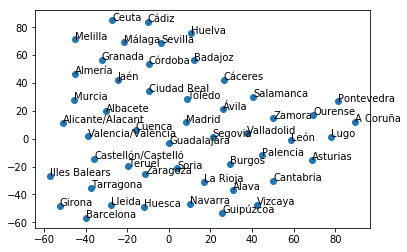

In [23]:
# Pintem les capitals de província
plt.scatter(x=tra[:,0], y=tra[:,1], cmap='viridis')
i = 0
for city in cityNames["from"]:
    plt.annotate(s = city, xy = (tra[i][0], tra[i][1]))
    i = i + 1
    
    



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> ¿s'assembla a la distribució de províncies real? ¿per què?
</div>

In [24]:
# No, no se sembla. La raó és perque l'algorisme transforma les dades intentant mantenir les distàncies.
# Podem comprovar que és correcte vañidant que les províncies estan agrupades segons la seva proximitat (les gallegues, 
 # les catalanes, ...). Podem veure, per exemple, que Balears queda aprop de Tarragona, Barcelona, València, ...

## 4. Aplicació: Agrupació de documents (3 punts)

### 4 a. Càrrega i neteja de dades

En aquest problema es farà servir el conjunt de dades [*20 news group*](https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20newsgroups.data.html), amb 20 categories de textos, dels quals se seleccionaran 3. L'objectiu és trobar grups de textos (preferiblement de la mateixa categoria) a través de les seves paraules.

El primer apartat consisteix a carregar el conjunt de dades i netejar les dades (tasca que normalment té una càrrega entre el 70 i 80% del temps), en aquest cas els textos.

In [25]:
data = datasets.fetch_20newsgroups(categories=['rec.autos', 'rec.sport.baseball', 'soc.religion.christian'])
texts, targets = data['data'], data['target']

On ```texts``` és una llista amb els articles i ```targets``` és un vector amb l'índex de la categoria a la qual pertany cada text.

La neteja de text ha de convertir:

In [262]:
print(data['data'][1])

evious article wharfie says In article Jim Frost writes larger engine That's what the SHO is slightly modified family sedan with powerful engine They didn't even bother improving the brakes That shows how much you know about anything The brakes on the SHO are very different inch or forget discs all around vented in front The normal Taurus setup is smaller discs front drums rear one saw had vented rears too it was on lot of course the sales man was fool titanium wheels yeah right then later told me they were magnesium more believable but still crap since Al is so uch cheaper and just as good tend to agree tho that this still doesn't take the SHO up to standard for running 130 on regular basis The brakes should be bigger like 11 or so take look at the ones on the Corrados where they have braking regulations DREW 


En quelcom semblant a:

```In previous article UUCP wharfie says In article centerline com com Jim Frost writes larger engine That's what the SHO is slightly modified family sedan with powerful engine They didn't even bother improving the *brakes That shows how much you know about anything The brakes on the SHO are very different inch or forget discs all around vented in front The normal Taurus setup is smaller discs front drums rear one saw had vented rears too it was on lot of course the sales man was fool titanium wheels yeah right then later told me they were magnesium more believable but still crap since Al is so uch cheaper and just as good tend to agree tho that this still doesn't take the SHO up to standard for running 130 on regular basis The brakes should be bigger like 11 or so take look at the ones on the Corrados where they have braking regulations DREW```

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> neteja els texts d'entrada:
<ul>
<li> Elimina les línies d'encapçalament.
<li> Els signes de puntuació.
<li> Els claudàtors, parèntesis i angulars.
<li> Els salts de línia.
<li> Exclamacions i interrogacions.
<li> Els tokens e-mails i de longitud 1.
<li> Els espais en blanc consecutius.
</ul>
</div>

In [256]:
import string
import re

retorn_carro = chr(10)

def elimina_linia(texte_a_tractar, txt):  
    while texte_a_tractar.find(txt) != -1:        
        posini = texte_a_tractar.find(txt)
        posfi = texte_a_tractar.find(retorn_carro, posini)        
        texte_a_tractar = texte_a_tractar[:posini] + texte_a_tractar[posfi:]           
    return texte_a_tractar

def tracta_texte(txt):
    # inicialitzem
    texte_a_tractar = txt
        
    # Eliminem l'encapçalament
    print("Eliminem l'encapçalament")
    texte_a_tractar = elimina_linia(texte_a_tractar, 'From:')
    texte_a_tractar = elimina_linia(texte_a_tractar, 'Subject:')
    texte_a_tractar = elimina_linia(texte_a_tractar, 'Organization:')
    texte_a_tractar = elimina_linia(texte_a_tractar, 'Lines:')
    texte_a_tractar = elimina_linia(texte_a_tractar, 'Reply-To:')
    texte_a_tractar = elimina_linia(texte_a_tractar, 'NNTP-Posting-Host:')
    texte_a_tractar = elimina_linia(texte_a_tractar, 'Rol:')
    texte_a_tractar = elimina_linia(texte_a_tractar, 'Re:')
    
    # Eliminem el continguts dels <>
    print("Eliminem el contingut dels <>")
    while texte_a_tractar.find('<') != -1:
        posini = texte_a_tractar.find('<')
        posfi = texte_a_tractar.find('>', posini)
        texte_a_tractar = texte_a_tractar[:posini] + texte_a_tractar[posfi+1:]

    # Els salts de línia
    print("-> Eliminem els retorn de carro")
    texte_a_tractar = texte_a_tractar.replace(retorn_carro, chr(32))    

    # Eliminem els emails 
    print("-> Eliminem els emails i tokens de longitud 1")
    paraules = texte_a_tractar.split()
    texte_auxiliar = ''
    for paraula in paraules:
        if paraula.find('@') == -1:
            texte_auxiliar = texte_auxiliar + paraula + chr(32)       
    texte_a_tractar = texte_auxiliar        
    # Els signes de puntuació
    # Els claudàtors, parèntesis i angulars
    # Exclamacions i interrogacions
    print("-> Eliminem els símbols (signes de puntuació, claudàtors, ...)")
    trantab = str.maketrans('.,():>-"?*', '          ')
    texte_a_tractar = texte_a_tractar.translate(trantab)

    # Eliminem els tokens de longitud 1
    paraules = texte_a_tractar.split()
    texte_auxiliar = ''
    for paraula in paraules:
        if len(paraula) > 1:
            texte_auxiliar = texte_auxiliar + paraula + chr(32)       
    texte_a_tractar = texte_auxiliar

    #Encara hi ha dobles espais en blanc; els eliminem
    print("-> Encara hi ha dobles espais en blanc; els eliminem")
    while texte_a_tractar.find(chr(32)+chr(32)) != -1:
        texte_a_tractar = texte_a_tractar.replace(chr(32)+chr(32), chr(32))       
    return texte_a_tractar
            
texte_tractat = tracta_texte(data['data'][1])
print("---------------------------------------------------------")    
print(texte_a_tractar)


Eliminem l'encapçalament
Eliminem el contingut dels <>
-> Eliminem els retorn de carro
-> Eliminem els emails i tokens de longitud 1
-> Eliminem els símbols (signes de puntuació, claudàtors, ...)
-> Encara hi ha dobles espais en blanc; els eliminem
---------------------------------------------------------
In previous article wharfie says In article Jim Frost writes larger engine That's what the SHO is slightly modified family sedan with powerful engine They didn't even bother improving the brakes That shows how much you know about anything The brakes on the SHO are very different inch or forget discs all around vented in front The normal Taurus setup is smaller discs front drums rear one saw had vented rears too it was on lot of course the sales man was fool titanium wheels yeah right then later told me they were magnesium more believable but still crap since Al is so uch cheaper and just as good tend to agree tho that this still doesn't take the SHO up to standard for running 130 on r

### 4 b. Conversió de texts a vectors

Per trobar grups entre els textos, cal convertir cada text en un vector. Hi ha multitud de maneres de fer-ho, una d'elles és aplicar [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) amb scikit-learn [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Transformant la llista de texts en una [matriu dispersa](https://docs.scipy.org/doc/scipy/reference/sparse.html) amb tantes files com articles i tantes columnes com paraules.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> transforma els texts a vectores con TF-IDF.

Per reduir el nombre de columnes en la matriu evita les *stop words* en anglès i converteix els texts a minúscules.
</div>

In [393]:
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from scipy.sparse import bsr_matrix

tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# Convertim a vertors
fitted_vectorizer = tfidf_vectorizer.fit(data['data'])
tfidf_vectorizer_vectors = fitted_vectorizer.transform(data['data'])
                

### 4 c. Reducció de dimensionalitat

Per visualitzar i trobar els grups, es reduirà la dimensionalitat de la matriu anterior. De tal manera que el nombre de columnes es reduirà a 2 (el nombre de files es manté, ja que cada fila és un document).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> utilitza t-SNE per reduir la dimensionalitat de <i> n </i> columnes (paraules) a 2 dimensions. Utilitza un tamany de perplexitat alt per augmentar el veïnatge (al voltant de 100).
</div>

In [395]:
tsne = manifold.TSNE(n_components=2, verbose=0, perplexity=120, n_iter=1000)
res = tsne.fit_transform(tfidf_vectorizer_vectors.toarray())
print(res.shape)

(1790, 2)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> visualitza mitjançant un scatter plot els punts en 2 dimensions amb un color per a cada classe.
</div>

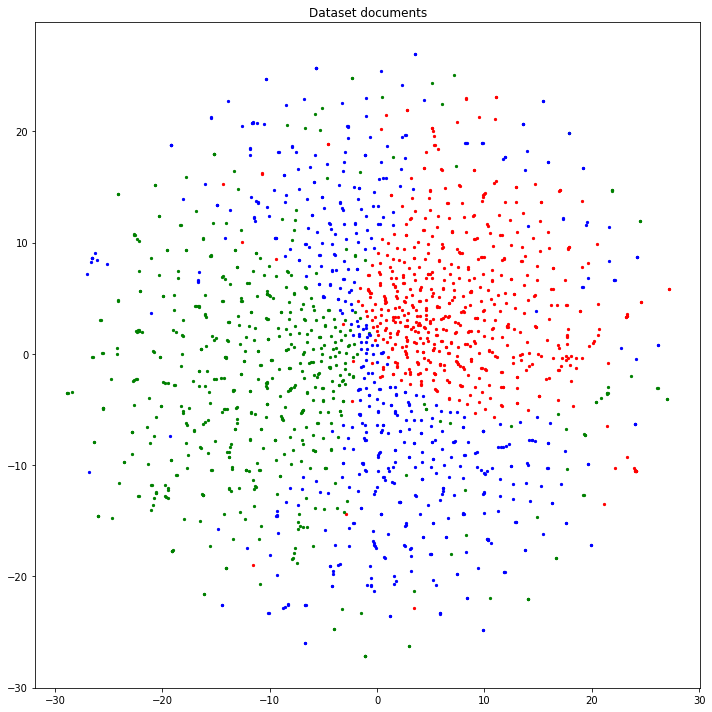

In [416]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range (len(res)):
    color = 'r'
    if data['target'][i] == 0:
        color = 'b'
    if data['target'][i] == 1:
        color = 'g'            
    ax.scatter(res[i][0], res[i][1], c=color, s=5)

ax.set_title('Dataset documents')    
plt.tight_layout()

### 4 d. Troba els grups d'articles amb diferents algorismes

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> utiliza <i>k-means</i> (amb <i>k=3</i>) per intentar trobar els 3 grups d'articles i visualitza el resultat.
</div>

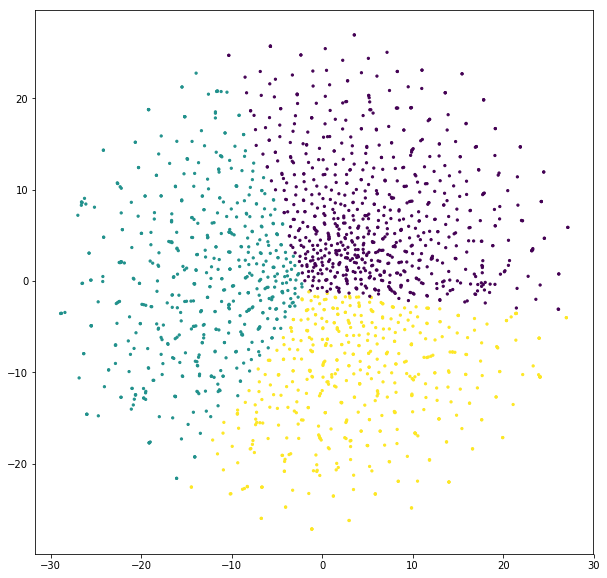

In [417]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit_transform(res)
y_kmeans = kmeans.predict(res)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.scatter(res[:, 0], res[:, 1], c=y_kmeans, s=5, cmap='viridis')
#plt.scatter(centroids[:,0], centroids[:,1], marker="x", color='r')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> ha localitzat els 3 grups originals? (el color no té perquè coincidir, només ens importa la forma). Per què?
</div>

In [ ]:
# La veritat és que no coincideix, però se sembla. 
# L'algirime 

Per agrupar els texts procurant situar els centroides en les regions més denses, [Mean-Shift](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html) segueix un camí des de qualsevol punt de l'espai guiant-se per la densitat de punts fins a assolir un màxim local (dins del seu <i> bandwidth </i>).

<br>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> utilitza <i>Mean-Shift</i> (variant en <i>bandwidth</i>) fins a trobar 3 grups i visualitza el resultat.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Ha localitzat els 3 grups originals? (el color no té perquè coincidir, només ens importa la forma). Per què?
</div>